In [1]:
import numpy as np
import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt
import os
import time

!pip install geopy
!pip install pgeocode
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from geopy.exc import GeocoderTimedOut, GeocoderQuotaExceeded
import pgeocode
import time

  Using cached geopy-2.1.0-py3-none-any.whl (112 kB)
  Using cached geographiclib-1.50-py3-none-any.whl (38 kB)
  Using cached pgeocode-0.3.0-py3-none-any.whl (8.5 kB)


### Load NAICS 6 Digit Dictionary

source: https://www.census.gov/naics/?48967

In [2]:
df_naics6 = pd.read_excel('6-digit_2017_Codes.xlsx', usecols=[0,1], dtype='str', skiprows=[1])
df_naics6.head()

<ipython-input-2-7f092fc433cd>:1: FutureWarning: Your version of xlrd is 1.2.0. In xlrd >= 2.0, only the xls format is supported. As a result, the openpyxl engine will be used if it is installed and the engine argument is not specified. Install openpyxl instead.
  df_naics6 = pd.read_excel('6-digit_2017_Codes.xlsx', usecols=[0,1], dtype='str', skiprows=[1])


,2017 NAICS Code,2017 NAICS Title
0,111110,Soybean Farming
1,111120,Oilseed (except Soybean) Farming
2,111130,Dry Pea and Bean Farming
3,111140,Wheat Farming
4,111150,Corn Farming


### Load HS NAICS Mapping File

source: https://dataweb.usitc.gov/classification/commodity-translation

In [3]:
#hs_to_naics = pd.read_csv('commodity_translation_wizard.csv')

In [10]:
#hs_to_naics['hs6'] = [str(x)[0:6] for x in hs_to_naics['hts10']]

In [5]:
#print("Num HTS10 rows: ", len(hs_to_naics['hts10']))
#print("Num unique HTS10 numbers: ", len(hs_to_naics['hts10'].unique()))
#print("Num unique HS6 numbers: ", len(hs_to_naics['hs6'].unique()))

Num HTS10 rows:  539515 \
Num unique HTS10 numbers:  31580 \
Num unique HS6 numbers:  7035 

In [22]:
#hs6_to_naics_mapping = hs_to_naics[['hs6', 'naics']].dropna(subset=['naics']).drop_duplicates()

In [27]:
#hs6_to_naics_mapping.to_csv('hs6_to_naics_mapping.csv')

### Load PPP Data

source: https://sba.app.box.com/s/5myd1nxutoq8wxecx2562baruz774si6

In [29]:
#df_ppp = pd.read_parquet('ppp_loans.parq')

In [31]:
#df_ppp.columns

Index(['LoanNumber', 'DateApproved', 'SBAOfficeCode', 'ProcessingMethod',
       'BorrowerName', 'BorrowerAddress', 'BorrowerCity', 'BorrowerState',
       'BorrowerZip', 'LoanStatusDate', 'LoanStatus', 'Term',
       'SBAGuarantyPercentage', 'InitialApprovalAmount',
       'CurrentApprovalAmount', 'UndisbursedAmount', 'FranchiseName',
       'ServicingLenderLocationID', 'ServicingLenderName',
       'ServicingLenderAddress', 'ServicingLenderCity', 'ServicingLenderState',
       'ServicingLenderZip', 'RuralUrbanIndicator', 'HubzoneIndicator',
       'LMIIndicator', 'BusinessAgeDescription', 'ProjectCity',
       'ProjectCountyName', 'ProjectState', 'ProjectZip', 'CD', 'JobsReported',
       'NAICSCode', 'RaceEthnicity', 'UTILITIES_PROCEED', 'PAYROLL_PROCEED',
       'MORTGAGE_INTEREST_PROCEED', 'RENT_PROCEED', 'REFINANCE_EIDL_PROCEED',
       'HEALTH_CARE_PROCEED', 'DEBT_INTEREST_PROCEED', 'BusinessType',
       'OriginatingLenderLocationID', 'OriginatingLender',
       'OriginatingLen

In [32]:
#df_ppp = df_ppp.dropna(subset=['NAICSCode'])

In [33]:
#print(len(df_ppp)) -5905815

5905815


### Join PPP Loan Data to NAICS Dictionary Lookup

In [57]:
#df_ppp_naics_join = pd.merge(df_ppp, df_naics6, left_on='NAICSCode', right_on='2017 NAICS Code')

In [58]:
#print('Num of PPP loans with valid NAICS codes: ', len(df_ppp_naics_join))

In [59]:
#df_ppp_naics_join.head()

In [60]:
#print(df_ppp_naics_join.columns)

#### Renamed the columns for the joined df

In [76]:
#df_ppp_naics_join.columns = ['LoanNumber', 'DateApproved', 'SBAOfficeCode', 'ProcessingMethod',
#                               'BorrowerName', 'BorrowerAddress', 'BorrowerCity', 'BorrowerState',
#                               'BorrowerZip', 'LoanStatusDate', 'LoanStatus', 'Term',
#                               'SBAGuarantyPercentage', 'InitialApprovalAmount',
#                               'CurrentApprovalAmount', 'UndisbursedAmount', 'FranchiseName',
#                               'ServicingLenderLocationID', 'ServicingLenderName',
#                               'ServicingLenderAddress', 'ServicingLenderCity', 'ServicingLenderState',
#                               'ServicingLenderZip', 'RuralUrbanIndicator', 'HubzoneIndicator',
#                               'LMIIndicator', 'BusinessAgeDescription', 'ProjectCity',
#                               'ProjectCountyName', 'ProjectState', 'ProjectZip', 'CD', 'JobsReported',
#                               'NAICSCode', 'RaceEthnicity', 'UTILITIES_PROCEED', 'PAYROLL_PROCEED',
#                               'MORTGAGE_INTEREST_PROCEED', 'RENT_PROCEED', 'REFINANCE_EIDL_PROCEED',
#                               'HEALTH_CARE_PROCEED', 'DEBT_INTEREST_PROCEED', 'BusinessType',
#                               'OriginatingLenderLocationID', 'OriginatingLender',
#                               'OriginatingLenderCity', 'OriginatingLenderState', 'Gender', 'Veteran',
#                               'NonProfit', 'OfficialNAICSCode', 'OfficialNAICSDescription']

In [77]:
#df_ppp_naics_join.to_parquet('ppp_loans_naics_join.parq')

### Reload Joined PPP-NAICS data from parquet

In [61]:
df_ppp_naics_join = pd.read_parquet('ppp_loans_naics_join.parq')

In [65]:
print('Num of PPP loans with valid NAICS codes: ', len(df_ppp_naics_join))

Num of PPP loans with valid NAICS codes:  5810835


### Quick analysis - top NAICS categories with the most number of PPP Loans

In [62]:
df_ppp_naics_count = pd.DataFrame(df_ppp_naics_join.groupby('OfficialNAICSDescription').count()['LoanNumber']).reset_index()

In [63]:
df_ppp_naics_count.columns = ['NAICS Category', 'NumPPPLoans']

In [64]:
df_ppp_naics_count.sort_values(by='NumPPPLoans', ascending=False).head(20)

,NAICS Category,NumPPPLoans
368,Full-Service Restaurants,220926
615,Offices of Lawyers,147009
624,Offices of Real Estate Agents and Brokers,140245
621,Offices of Physicians (except Mental Health Sp...,127974
614,Offices of Dentists,124800
107,Beauty Salons,112842
453,Insurance Agencies and Brokerages,99499
849,Religious Organizations,96557
494,Limited-Service Restaurants,94899
53,All Other Personal Services,86912


In [105]:
df_ppp_naics_count.sort_values(by='NumPPPLoans', ascending=False).tail(10)

,NAICS Category,NumPPPLoans
246,"Cyclic Crude, Intermediate, and Gum and Wood C...",20
493,Lime Manufacturing,19
305,"Executive and Legislative Offices, Combined",18
473,Kaolin and Ball Clay Mining,17
795,"Potash, Soda, and Borate Mineral Mining",14
766,Phosphatic Fertilizer Manufacturing,14
189,Commuter Rail Systems,13
915,Silver Ore Mining,10
112,Beet Sugar Manufacturing,10
1023,Uranium-Radium-Vanadium Ore Mining,9


### Get lat-long for each PPP loan zip code

https://stackoverflow.com/questions/58439692/convert-physical-addresses-to-geographic-locations-latitude-and-longitude \
https://pypi.org/project/pgeocode/

In [67]:
#Combine the full address
df_ppp_naics_join['full_address'] = df_ppp_naics_join['BorrowerAddress'] + " " + \
                                    df_ppp_naics_join['BorrowerCity']    + " " + \
                                    df_ppp_naics_join['BorrowerState']   + " " + \
                                    df_ppp_naics_join['BorrowerZip']
            
#Drop records with Null addresses
df_ppp_naics_join_address = df_ppp_naics_join.dropna(subset=['full_address'])
print('Num of PPP loans with valid NAICS codes AND addresses: ', len(df_ppp_naics_join_address))

Num of PPP loans with valid NAICS codes AND addresses:  5810646


In [68]:
df_ppp_naics_join_address.head()

,LoanNumber,DateApproved,SBAOfficeCode,ProcessingMethod,BorrowerName,BorrowerAddress,BorrowerCity,BorrowerState,BorrowerZip,LoanStatusDate,...,OriginatingLenderLocationID,OriginatingLender,OriginatingLenderCity,OriginatingLenderState,Gender,Veteran,NonProfit,OfficialNAICSCode,OfficialNAICSDescription,full_address
1,2743777209,04/16/2020,0459,PPP,MOBILE PAINT MANUFACTURING COMPANY OF DELAWARE...,"4775 Hamilton Blvd,",Theodore,AL,36582-8509,None,...,2408,Regions Bank,BIRMINGHAM,AL,Unanswered,Unanswered,None,325510,Paint and Coating Manufacturing,"4775 Hamilton Blvd, Theodore AL 36582-8509"
2,4993247205,04/27/2020,0459,PPP,ABC APPLICATORS INC,4470 McCrary Road,SEMMES,AL,36575-4440,None,...,39217,Community Bank of Mississippi,FOREST,MS,Male Owned,Non-Veteran,None,325510,Paint and Coating Manufacturing,4470 McCrary Road SEMMES AL 36575-4440
3,5470787100,04/13/2020,0459,PPP,"TITAN COATINGS, INC.",2025 Exchange Place,BESSEMER,AL,35022-5650,12/16/2020,...,2408,Regions Bank,BIRMINGHAM,AL,Unanswered,Unanswered,None,325510,Paint and Coating Manufacturing,2025 Exchange Place BESSEMER AL 35022-5650
4,6497257001,04/07/2020,0459,PPP,INDURON COATINGS LLC,3333 RICHARD ARRINGTON JR BLVD,BIRMINGHAM,AL,35234-2303,None,...,434138,ServisFirst Bank,BIRMINGHAM,AL,Unanswered,Unanswered,None,325510,Paint and Coating Manufacturing,3333 RICHARD ARRINGTON JR BLVD BIRMINGHAM AL 3...
5,1026398408,01/31/2021,0459,PPS,MAX COATING INC.,3653 Industrial Pkwy,Birmingham,AL,35217-1346,01/31/2021,...,19248,Synovus Bank,COLUMBUS,GA,Unanswered,Unanswered,None,325510,Paint and Coating Manufacturing,3653 Industrial Pkwy Birmingham AL 35217-1346


In [252]:
print(len([x[0:5] for x in df_ppp_naics_join_address['BorrowerZip']]))
print(len(set([x[0:5] for x in df_ppp_naics_join_address['BorrowerZip']])))

5810646
36627


In [ ]:
#Extract unique zip codes
unique_zip_codes = set([x[0:5] for x in df_ppp_naics_join_address['BorrowerZip']])

In [253]:
#Initialize package and query lat long for all unique zips
nomi = pgeocode.Nominatim('us')
df_zip_code_lat_long = nomi.query_postal_code(unique_zip_codes)

In [254]:
df_zip_code_lat_long.head(2)

,postal_code,country_code,place_name,state_name,state_code,county_name,county_code,community_name,community_code,latitude,longitude,accuracy
0,29645,US,Gray Court,South Carolina,SC,Laurens,59.0,NaN,NaN,34.5953,-82.1147,4.0
1,83874,US,Murray,Idaho,ID,Shoshone,79.0,NaN,NaN,47.6271,-115.8585,4.0


In [255]:
df_ppp_naics_join_address['ZIP5'] = [x[0:5] for x in df_ppp_naics_join_address['BorrowerZip']]

<ipython-input-255-27eca24948aa>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ppp_naics_join_address['ZIP5'] = [x[0:5] for x in df_ppp_naics_join_address['BorrowerZip']]


In [256]:
df_ppp_naics_join_address.head(5)

,LoanNumber,DateApproved,SBAOfficeCode,ProcessingMethod,BorrowerName,BorrowerAddress,BorrowerCity,BorrowerState,BorrowerZip,LoanStatusDate,...,OriginatingLender,OriginatingLenderCity,OriginatingLenderState,Gender,Veteran,NonProfit,OfficialNAICSCode,OfficialNAICSDescription,full_address,ZIP5
1,2743777209,04/16/2020,0459,PPP,MOBILE PAINT MANUFACTURING COMPANY OF DELAWARE...,"4775 Hamilton Blvd,",Theodore,AL,36582-8509,None,...,Regions Bank,BIRMINGHAM,AL,Unanswered,Unanswered,None,325510,Paint and Coating Manufacturing,"4775 Hamilton Blvd, Theodore AL 36582-8509",36582
2,4993247205,04/27/2020,0459,PPP,ABC APPLICATORS INC,4470 McCrary Road,SEMMES,AL,36575-4440,None,...,Community Bank of Mississippi,FOREST,MS,Male Owned,Non-Veteran,None,325510,Paint and Coating Manufacturing,4470 McCrary Road SEMMES AL 36575-4440,36575
3,5470787100,04/13/2020,0459,PPP,"TITAN COATINGS, INC.",2025 Exchange Place,BESSEMER,AL,35022-5650,12/16/2020,...,Regions Bank,BIRMINGHAM,AL,Unanswered,Unanswered,None,325510,Paint and Coating Manufacturing,2025 Exchange Place BESSEMER AL 35022-5650,35022
4,6497257001,04/07/2020,0459,PPP,INDURON COATINGS LLC,3333 RICHARD ARRINGTON JR BLVD,BIRMINGHAM,AL,35234-2303,None,...,ServisFirst Bank,BIRMINGHAM,AL,Unanswered,Unanswered,None,325510,Paint and Coating Manufacturing,3333 RICHARD ARRINGTON JR BLVD BIRMINGHAM AL 3...,35234
5,1026398408,01/31/2021,0459,PPS,MAX COATING INC.,3653 Industrial Pkwy,Birmingham,AL,35217-1346,01/31/2021,...,Synovus Bank,COLUMBUS,GA,Unanswered,Unanswered,None,325510,Paint and Coating Manufacturing,3653 Industrial Pkwy Birmingham AL 35217-1346,35217


In [258]:
df_ppp_naics_address_lat_long = pd.merge(df_ppp_naics_join_address, 
                                         df_zip_code_lat_long[['postal_code', 'place_name', 'state_name', 'state_code','latitude', 'longitude']], 
                                         left_on='ZIP5', right_on='postal_code')

In [259]:
df_ppp_naics_address_lat_long.head()

,LoanNumber,DateApproved,SBAOfficeCode,ProcessingMethod,BorrowerName,BorrowerAddress,BorrowerCity,BorrowerState,BorrowerZip,LoanStatusDate,...,OfficialNAICSCode,OfficialNAICSDescription,full_address,ZIP5,postal_code,place_name,state_name,state_code,latitude,longitude
0,2743777209,04/16/2020,0459,PPP,MOBILE PAINT MANUFACTURING COMPANY OF DELAWARE...,"4775 Hamilton Blvd,",Theodore,AL,36582-8509,None,...,325510,Paint and Coating Manufacturing,"4775 Hamilton Blvd, Theodore AL 36582-8509",36582,36582,Theodore,Alabama,AL,30.5444,-88.1807
1,5769087303,04/30/2020,0459,PPP,OAKRIDGE SERVICES LLC,5685B I-10 Industrial Pky \r\nNorth,Theodore,AL,36582,None,...,561730,Landscaping Services,5685B I-10 Industrial Pky \r\nNorth Theodore A...,36582,36582,Theodore,Alabama,AL,30.5444,-88.1807
2,8287317410,05/18/2020,0459,PPP,"BILL BAFF LANDSCAPE, INC.",9830 BELLINGRATH RD,THEODORE,AL,36582,None,...,561730,Landscaping Services,9830 BELLINGRATH RD THEODORE AL 36582,36582,36582,Theodore,Alabama,AL,30.5444,-88.1807
3,3468087300,04/29/2020,0459,PPP,MARK YANCEY,9781 OLD PASCAGOULA RD,THEODORE,AL,36582,None,...,561730,Landscaping Services,9781 OLD PASCAGOULA RD THEODORE AL 36582,36582,36582,Theodore,Alabama,AL,30.5444,-88.1807
4,6138817001,04/06/2020,0459,PPP,"G BRIAN LINDSEY ENTERPRISES, LLC",3820 LE BLANC DR,THEODORE,AL,36582-2536,None,...,561730,Landscaping Services,3820 LE BLANC DR THEODORE AL 36582-2536,36582,36582,Theodore,Alabama,AL,30.5444,-88.1807


In [260]:
#df_ppp_naics_address_lat_long.to_parquet('ppp_loans_naics_lat_long.parq')

In [276]:
#df_ppp_naics_address_lat_long = pd.read_parquet('ppp_loans_naics_lat_long.parq')

#### PPP by State Count (for those with full addresses)

In [96]:
ppp_naics_count_by_state = pd.DataFrame(df_ppp_naics_join_address.groupby(by='BorrowerState').count()['LoanNumber'].reset_index())

<BarContainer object of 58 artists>

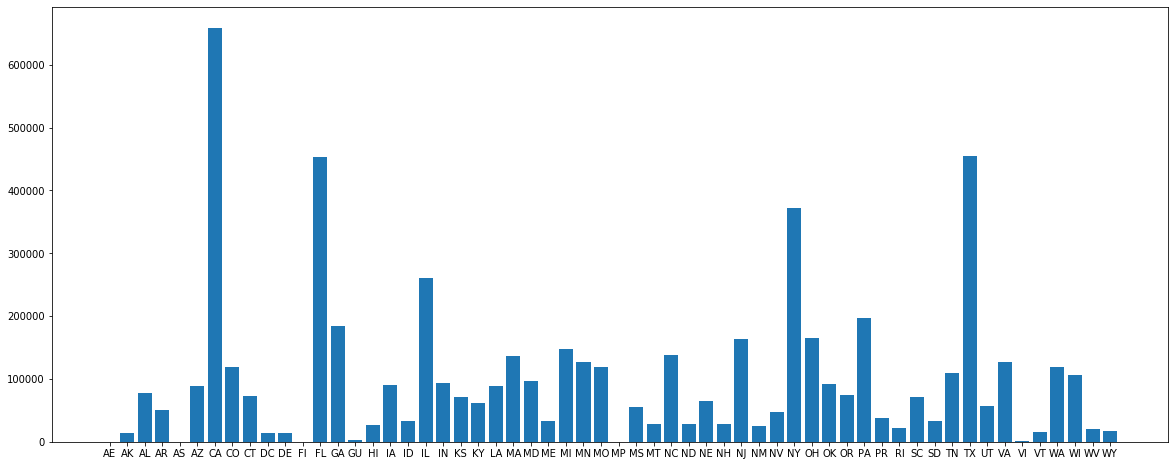

In [104]:
import matplotlib.pyplot as plt
%matplotlib inline  
plt.figure(figsize=(20,8)) 
plt.bar(x=ppp_naics_count_by_state.BorrowerState, height=ppp_naics_count_by_state.LoanNumber)

#### Sample PPP data for each NAICS code

In [277]:
unique_naics = list(df_ppp_naics_address_lat_long['OfficialNAICSCode'].unique())
print(len(unique_naics))

1057


In [278]:
def ppp_naics_address_sample_by_naics():
    ret_df = pd.DataFrame(columns = df_ppp_naics_address_lat_long.columns)
    i = 0
    for n in unique_naics:
        sample_size = 5
        i+=5
        if(i in np.arange(0,10000,500)):
            print("Iteration {} ".format(i))        
        tempdf = df_ppp_naics_address_lat_long[df_ppp_naics_address_lat_long['OfficialNAICSCode']==n].sample(n=sample_size, random_state=99)        
        ret_df = pd.concat([ret_df, tempdf])
    return ret_df

In [279]:
df_ppp_naics_address_lat_long_sample = ppp_naics_address_sample_by_naics()

Iteration 500 
Iteration 1000 
Iteration 1500 
Iteration 2000 
Iteration 2500 
Iteration 3000 
Iteration 3500 
Iteration 4000 
Iteration 4500 
Iteration 5000 


In [280]:
len(df_ppp_naics_address_lat_long_sample)

5285

In [282]:
#df_ppp_naics_address_lat_long_sample.to_parquet('ppp_loans_naics_lat_long_sample.parq')